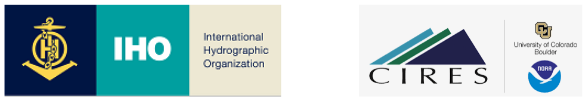


## Crowdsourced Bathymetry Data (CSB) Visualization

In 2014, the International Hydrographic Organization (IHO) initiated a collaborative project to enable mariners to collect “crowdsourced bathymetry”. CSB is the collection of depth measurements from vessels, using standard navigation instruments, while engaged in routine maritime operations. NCEI built a new data pipeline that allows the public to contribute CSB data, and then discover and download data via a web-based map viewer interface. New point based extact services are under development using a serverless database solution (Athena).

This notebook sends an extract request to a data lake of crowdsourced bathymetry data stored as csv files on s3 and available through an AWS Athena service stored in parquet format. After generating a subset of the data within our geographic bounding box we can visualize the results as a 3D plot. The data lake hosted by the NOAA Big Data Project contains nearly 100,000,000 unique depth soundings from over 135 participating ships!

Read more here: https://noaa-bathymetry-pds.s3.amazonaws.com/readme.html

Or browse the bucket here: https://noaa-bathymetry-pds.s3.amazonaws.com/index.html

This notebook is available here:
https://github.com/dneufeldcu/notebooks/blob/main/esipCSBfinal.ipynb

### Set-up 
- conda activate base
- conda config --add channels conda-forge --force
- conda install mamba
- mamba update --yes --all
- mamba create -n holoviz datashader geoviews hvplot ipyleaflet matplot

### Step 1. 
Let's import numby and matplot, hvplot and ipyleaflet (etc.) to support the visualizations, and smart-open in order to read the csv file from s3.

In [ ]:
import time
import csv
import requests
import numpy as np
import matplotlib.pyplot as plt
from smart_open import open as sm_open
from ipyleaflet import Map, WMSLayer, basemaps
import pandas as pd
import hvplot.pandas
import cartopy
import geoviews


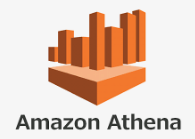
### Step 2.
Write a generic HTTP request. We'll populate the url with our Athena service endpoint and our JSON payload will contain our extract parameters.


In [ ]:
def extract_request(url, payload):
    print(f'Request url: {url}')  
    print(f'Payload: {payload}')
    r = requests.post(url, json=payload)
    print(r.status_code)
    return r.json()


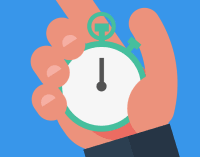
### Step 3.
Because our extract service is ansychronous we'll need poll the job status endpoint for status

In [ ]:
def job_status(response):
    time.sleep(3)
    # Use a breakpoint in the code line below to debug your script.
    response_url = response['url']
    print(f'Job Status Endpoint: {response_url}')  # Press ⌘F8 to toggle the breakpoint.

    r = requests.get(response_url)
    return r

### Step 4.
Our main execution flow let's submit an extract request for depth soundings near the San Diego airport based on the extent of our map.


In [ ]:
center = (32.715,-117.209)

map = Map(basemap=basemaps.Esri.NatGeoWorldMap, center=center, zoom=9)

wms = WMSLayer(
    url='https://gis.ngdc.noaa.gov/arcgis/services/csb/MapServer/WMSServer',
    layers='1',
    format='image/png',
    transparent=True,
)
map.add_layer(wms)
display(map)


In [ ]:
# Grab the geographic extent from the map bounds

extent = f"{map.bounds[0][1]},{map.bounds[0][0]},{map.bounds[1][1]},{map.bounds[1][0]}"
print (extent)
payload = {}
payload['email'] = "david.neufeld@noaa.gov"
payload['bbox'] = extent
print(str(payload))

# Submit to the Athena service
response = extract_request('https://q20bz02j8b.execute-api.us-east-1.amazonaws.com/extract-request', payload)
status_response = job_status(response)

# Poll until the service can find the new job (rare)
while status_response.status_code == 404:
    print("sleeping...")
    time.sleep(3)
    status_response = job_status(response)
    print(status_response.status_code)

# Poll the new job until it succeeds
job_payload = status_response.json()
print(job_payload['status'])
while str(job_payload['status']) == "RUNNING":
    print(f"Job is still {job_payload['status']}")
    print("sleep...")
    time.sleep(3)
    status_response = job_status(response)
    job_payload = status_response.json()
    print(status_response.status_code)

print("SUCCESS!: ", job_payload['url'])
s3_url = job_payload['url']

In [ ]:
# Let's look at the data data
df = pd.read_csv(s3_url)
df.head()

In [ ]:
# Let's use smart_open to read directly from our s3 object to use with matplot
# Read more about smart_open here - https://pypi.org/project/smart-open/
def get_csv_s3(url):
    sm_open_file = sm_open(url, 'r')
    return sm_open_file

In [ ]:
# Lastly let's visualize our data
# Are there any outliers?
def visualize(s3_url):
    # Read CSV
    csv_data = []
    csv_file = get_csv_s3(s3_url)

    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    for csv_row in csv_reader:
        if i > 0:
            csv_data.append([csv_row[0], csv_row[1], csv_row[2]])
        i = i + 1

    # Get X, Y, Z
    csv_data = np.array(csv_data)
    csv_data = csv_data.astype( np.float )
    x, y, z = csv_data[:, 0], csv_data[:, 1], (csv_data[:, 2] * -1)

    # Plot X,Y,Z
    fig = plt.figure()
    ax = fig.add_subplot( 111, projection='3d' )
    ax.plot_trisurf(x, y, z, color='white', edgecolors='grey', alpha=0.5)
    ax.scatter(x, y, z, c = 'red')
    plt.show()

In [ ]:
# Now visualize the file with matplot
visualize(s3_url)

In [ ]:
# Let's invert depth values so red is shallow and blue is deep
# Depth is in meters
def multiply_by_neg_one(arr):
    return np.multiply(arr,-1)

df['inverted_depth'] = df[['depth']].apply(multiply_by_neg_one)

In [ ]:
# Now visualize with hvplot

df.hvplot.points(x='lon', y='lat', color='inverted_depth', rasterize=True, 
                 geo=True, cmap='turbo', frame_width=600, tiles='OSM', hover=False)


In [ ]:
print("Thank you, any questions?!")

Credits:
 - David Neufeld, Jupyter Notebook
 - Ken Tanaka, Bucket management
 - Patrick Keown, Jonathan Brannock, BDP
 - Jennifer Jencks, NOAA NCEI Project Manager
 - John Cartwright, NOAA NCEI/CIRES Athena
 - Rich Signell, USGS Juptyer Advisor